##  Homework 5 : Harshita Mahesh Hiremath

In [188]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

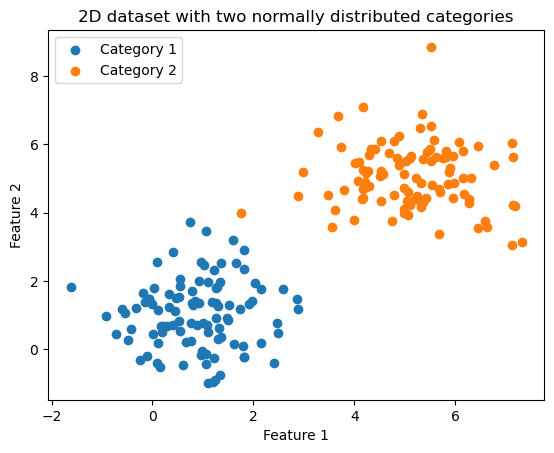

In [189]:
def generate_2d_dataset():
    
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate data for the first category with mean (1, 1) and standard deviation 1
    category1 = np.random.normal(loc=(1, 1), scale=1, size=(100, 2))
    
    # Generate data for the second category with mean (5, 5) and standard deviation 1
    category2 = np.random.normal(loc=(5, 5), scale=1, size=(100, 2))
    
    # Combine the two categories into one dataset
    dataset = np.vstack([category1, category2])
    
    return dataset

def visualize(data_2d):
    
    # Create a scatter plot
    plt.scatter(data_2d[:, 0][:100], data_2d[:, 1][:100], label='Category 1', marker='o')
    plt.scatter(data_2d[:, 0][100:], data_2d[:, 1][100:], label='Category 2', marker='o')

    # Set labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D dataset with two normally distributed categories')

    # Add legend
    plt.legend()
    
# Generate 2D dataset
data_2d = generate_2d_dataset()
visualize(data_2d)
# Display the plot
plt.show()

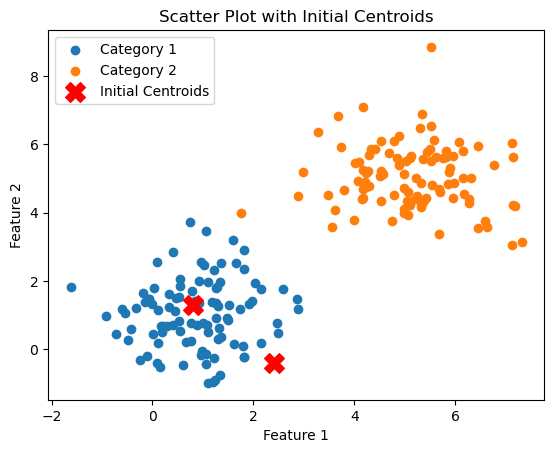

In [190]:
# Euclidean distance function
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Function to initialize centroids randomly
def initialize_centroids(data, k):
    indices = np.random.choice(len(data), size=k, replace=False)
    centroids = data[indices]
    return centroids

# Initialize centroids
k = 2
centroids = initialize_centroids(data_2d, k)

# Create a scatter plot of the data
visualize(data_2d)

# Highlight the initial centroids
plt.scatter(centroids[:, 0], centroids[:, 1], label='Initial Centroids', marker='X', s=200, c='red')

# Set labels and title
plt.title('Scatter Plot with Initial Centroids')

# Add legend
plt.legend()

# Display the plot
plt.show()

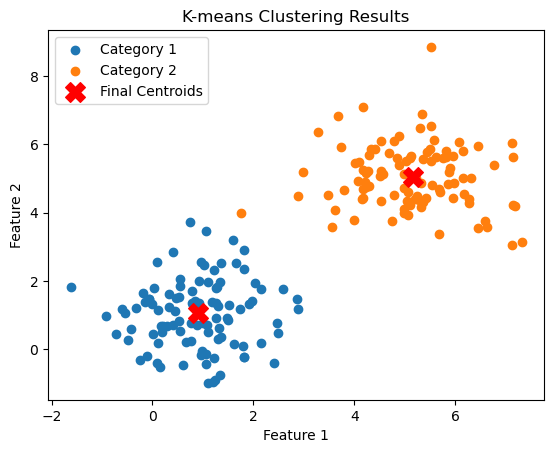

In [191]:
# Function to assign each point to the nearest centroid
def assign_cluster(data, centroids):
    clusters = [[] for _ in range(len(centroids))]
    
    for point in data:
        distances = [distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        clusters[closest_centroid].append(point)
    
    return clusters

# Function to update centroids based on the mean of points in each cluster
def update_centroids(clusters):
    new_centroids = [np.mean(cluster, axis=0) for cluster in clusters]
    return new_centroids

# K-means algorithm
def k_means(data, k):
    centroids = initialize_centroids(data, k)
    
    while True:
        old_centroids = centroids.copy()
        
        # Assign each point to the nearest centroid
        clusters = assign_cluster(data, centroids)
        
        # Update centroids based on the mean of points in each cluster
        centroids = update_centroids(clusters)
        
        # Check for convergence
        if np.allclose(old_centroids, centroids):
            break
    
    return clusters, centroids

# Apply K-means algorithm
k = 2
clusters, final_centroids = k_means(data_2d, k)
final_centroids = np.array(final_centroids)

# Visualize the result
visualize(data_2d)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], marker='X', s=200, c='red', label='Final Centroids')

# Set labels and title
plt.title('K-means Clustering Results')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [192]:
def read_idx(filename):
    with gzip.open(filename,'rb') as f:
        zero,data_type, dims = struct.unpack('>HBB',f.read(4))
        shape = tuple(struct.unpack('>I',f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(),dtype=np.uint8).reshape(shape)

In [193]:
train_images = read_idx('HW 4/train-images-idx3-ubyte.gz')
train_labels = read_idx('HW 4/train-labels-idx1-ubyte.gz')
test_images = read_idx('HW 4/t10k-images-idx3-ubyte.gz')
test_labels = read_idx('HW 4/t10k-labels-idx1-ubyte.gz')

In [194]:
# Flatten the data
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Normalize the data
normalized_train_images = train_images_flattened / 255.0
normalized_test_images = test_images_flattened / 255.0

In [195]:
train_images_flattened.shape

(60000, 784)

In [196]:
# Define the number of clusters (K)
k_mnist = 10

# Record the start time
start_time = datetime.datetime.now()

# Train K-means model
kmeans = KMeans(n_clusters=k_mnist, random_state=42)
kmeans.fit(normalized_train_images)

# Record the end time
end_time = datetime.datetime.now()

# Calculate the time difference
training_time = end_time - start_time

print(f"Training time for K-means with {k_mnist} clusters: {training_time}")

Training time for K-means with 10 clusters: 0:00:18.740225


In [197]:
# Function to assign labels to clusters based on the most common true label
def assign_labels_to_clusters(clusters, true_labels, k):
    labels = np.zeros_like(clusters)
    for i in range(k):
        mask = (clusters == i)
        # Assign the most common label to the centroid
        labels[mask] = np.bincount(true_labels[mask]).argmax()
    return labels

# Function to calculate accuracy based on cluster-based labels
def manual_accuracy_score(true_labels, predicted_labels):
    correct_predictions = sum(p == t for p, t in zip(predicted_labels, true_labels))
    accuracy = correct_predictions / len(true_labels)
    return accuracy

In [198]:
# Define different values of K
k_values = [10, 16, 64, 256]
accuracy_list = []
inertia_list = []

# Iterate over different values of K
for k in k_values:
    # Train Mini-Batch K-means model
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_train_images)  # Using the test set for demonstration purposes
    
    inertia_value = kmeans.inertia_
    inertia_list.append(inertia_value)
    print(f"K = {k}, Inertia Value: {round(inertia_value,3)}")

K = 10, Inertia Value: 2373981.223
K = 16, Inertia Value: 2227549.817
K = 64, Inertia Value: 1803337.625
K = 256, Inertia Value: 1504144.501


In [199]:
# Choose the best K based on inertia (lower is better)
best_k_inertia = k_values[inertia_list.index(min(inertia_list))]  # Replace with the value of K that minimizes inertia

# Apply the best model to the test dataset
best_kmeans = MiniBatchKMeans(n_clusters=best_k_inertia, random_state=42)
best_kmeans.fit(normalized_test_images)

# Assign labels to clusters based on the most common true label
best_cluster_labels = assign_labels_to_clusters(best_kmeans.labels_, test_labels, best_k_inertia)

best_inertia = best_kmeans.inertia_
print(f"Best Model based on inertia (K = {best_k_inertia}), Inertia Value on Test Data: {round(best_inertia,3)}")

Best Model based on inertia (K = 256), Inertia Value on Test Data: 240033.974


In [200]:
# Choose the best K based on accuracy (higher is better)
best_k_acc = 256  # Replace with the value of K that maximizes accuracy

# Apply the best model to the test dataset
best_kmeans = MiniBatchKMeans(n_clusters=best_k_acc, random_state=42)
best_kmeans.fit(normalized_test_images)

# Assign labels to clusters based on the most common true label
best_cluster_labels = assign_labels_to_clusters(best_kmeans.labels_, test_labels, best_k_acc)

# Calculate accuracy based on cluster-based labels
best_accuracy = manual_accuracy_score(test_labels, best_cluster_labels)
print(f"Best Model based on accuracy (K = {best_k_acc}), Accuracy on Test Data: {best_accuracy}")

Best Model based on accuracy (K = 256), Accuracy on Test Data: 0.8942
